# Importing Libraries


In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn import MSELoss
from torch.optim import AdamW


import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

/Users/taimourabdulkarim/miniconda3/envs/mlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download the 'punkt' tokenizer data
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/taimourabdulkarim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taimourabdulkarim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Importing Dataset


In [4]:
prompt_train = pd.read_csv(
    "Dataset/commonlit-evaluate-student-summaries/prompts_train.csv"
)
prompt_test = pd.read_csv(
    "Dataset/commonlit-evaluate-student-summaries/prompts_test.csv"
)

summary_train = pd.read_csv(
    "Dataset/commonlit-evaluate-student-summaries/summaries_train.csv"
)
summary_test = pd.read_csv(
    "Dataset/commonlit-evaluate-student-summaries/summaries_test.csv"
)

In [5]:
prompt_train.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [6]:
prompt_test.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


In [7]:
summary_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [8]:
summary_test.head()

,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


# Data Preprocessing


### Merge the Datasets

merging the train data on basis of promptId


In [9]:
df_train = pd.merge(prompt_train, summary_train, on="prompt_id")
df_test = pd.merge(prompt_test, summary_test, on="prompt_id")

In [10]:
# take only first 10 rows for now
# df_train = df_train.head(10)

In [11]:
df_train.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886


In [12]:
# print the unique values of the 'prompt_title' column
print(df_train["prompt_title"].unique())

['On Tragedy' 'Egyptian Social Structure' 'The Third Wave'
 'Excerpt from The Jungle']


In [13]:
# take 50 random rows for each prompt_title
df_train = (
    df_train.groupby("prompt_title")
    .apply(lambda x: x.sample(n=50))
    .reset_index(drop=True)
)
df_train.shape

/var/folders/0p/qyx6hw_n0xjbkx26s_w74m000000gn/T/ipykernel_1677/238483951.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train.groupby("prompt_title")


(200, 8)

In [14]:
print(df_train["prompt_title"].unique())

['Egyptian Social Structure' 'Excerpt from The Jungle' 'On Tragedy'
 'The Third Wave']


In [15]:
df_train.columns

Index(['prompt_id', 'prompt_question', 'prompt_title', 'prompt_text',
       'student_id', 'text', 'content', 'wording'],
      dtype='object')

In [16]:
# only keep text and score columns
df_train = df_train[["text", "content", "wording"]]

In [23]:
import random

In [24]:
def simulate_adhd_writing(summary):
    # Function to introduce occasional spelling mistakes
    def add_spelling_mistakes(word):
        if random.random() < 0.2:  # 20% chance of introducing a mistake
            position = random.randint(0, len(word) - 1)
            return (
                word[:position]
                + random.choice("abcdefghijklmnopqrstuvwxyz")
                + word[position:]
            )
        else:
            return word

    # Function to use informal language and slang
    def add_slang(word):
        slang_dict = {
            "awesome": "totally awesome",
            "cool": "super cool",
            "friend": "buddy",
            "amazing": "crazy cool",
        }
        return slang_dict.get(word, word)

    words = summary.split()

    # Introduce spelling mistakes
    words = [add_spelling_mistakes(word) for word in words]

    # Use informal language and slang
    words = [add_slang(word) for word in words]

    # Vary sentence lengths
    new_summary = ""
    sentence_length = random.randint(3, 10)
    for i, word in enumerate(words):
        if i % sentence_length == 0 and i != 0:
            new_summary += ". "  # End the previous sentence
            sentence_length = random.randint(
                3, 10
            )  # Randomly determine the next sentence length
        new_summary += " " + word

    # Add a positive tone
    new_summary = f"{new_summary.strip()}. It was like, so amazing!"

    return new_summary

In [25]:
df_train["adhd_text"] = df_train["text"].apply(simulate_adhd_writing)

In [32]:
import random
import math


def sigmoid(x):
    return 1 / (1 + math.exp(-x))


def adjust_scores_for_adhd(content_score, wording_score):
    # Adjust content score for ADHD style
    content_adjustment = random.uniform(-2.00000, 2.000000)
    adjusted_content_score = sigmoid(content_score + content_adjustment)

    # Adjust wording score for ADHD style
    wording_adjustment = random.uniform(-2.000000, 2.000000)
    adjusted_wording_score = sigmoid(wording_score + wording_adjustment)

    return adjusted_content_score, adjusted_wording_score

In [33]:
df_train["adhd_content_score"], df_train["adhd_wording_score"] = zip(
    *df_train.apply(
        lambda x: adjust_scores_for_adhd(x["content"], x["wording"]), axis=1
    )
)

In [16]:
df_train

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,ded6a14b4c27,In the structure of the ancient Egyptian gover...,-0.301962,0.077857
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,95c8b1d33694,"In the ancient Egyptian system of government, ...",-0.066112,-0.715083
2,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,55918828da86,The a try tire of ancient Egypt is they belove...,-0.974242,-0.751414
3,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,e70311747892,The pharoah is at the top and is seen as the s...,0.610711,1.216344
4,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,875c0d066910,Different social classes were involved in this...,0.088882,-0.594710
...,...,...,...,...,...,...,...,...
195,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,be6dddc74b14,It started off with the question Ron Jones fou...,3.108995,1.495397
196,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,5f5d3ecc6779,The Third Wave was an experiment that tested t...,1.690740,1.461055
197,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,1dc0c8ae7019,The Third Wave was tremendously effective. It ...,-0.676259,0.670956
198,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,21c30b4863fd,Ron Jones created some sort of dictatorship in...,2.926299,2.593940


In [17]:
# save the dataframe to a csv file
df_train.to_csv("df_train.csv")

# Exploratory Data Analysis (EDA)


In [16]:
df_train.shape

(10, 8)

In [17]:
# save the first 5 rows of df_train to a csv file
df_train.head().to_csv("df_train.csv")

In [18]:
df_train.columns

Index(['prompt_id', 'prompt_question', 'prompt_title', 'prompt_text',
       'student_id', 'text', 'content', 'wording'],
      dtype='object')

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   prompt_id        10 non-null     object 
 1   prompt_question  10 non-null     object 
 2   prompt_title     10 non-null     object 
 3   prompt_text      10 non-null     object 
 4   student_id       10 non-null     object 
 5   text             10 non-null     object 
 6   content          10 non-null     float64
 7   wording          10 non-null     float64
dtypes: float64(2), object(6)
memory usage: 768.0+ bytes


In [20]:
df_train.describe()

,content,wording
count,10.000000,10.000000
mean,-0.465559,-0.432527
std,0.926348,1.029566
min,-1.547163,-1.505073
25%,-1.190720,-1.244611
50%,-0.537539,-0.527798
75%,0.014008,-0.428015
max,1.199642,1.551633


In [21]:
# Check for duplicate rows
print("Duplicate Rows:", df_train.duplicated().sum())

Duplicate Rows: 0


In [22]:
print("Null Values:", df_train.isnull().sum())  # Check for null values

Null Values: prompt_id          0
prompt_question    0
prompt_title       0
prompt_text        0
student_id         0
text               0
content            0
wording            0
dtype: int64


In [23]:
# print unique values of every column
for col in df_train.columns:
    print(col, df_train[col].nunique())

prompt_id 1
prompt_question 1
prompt_title 1
prompt_text 1
student_id 10
text 10
content 9
wording 9


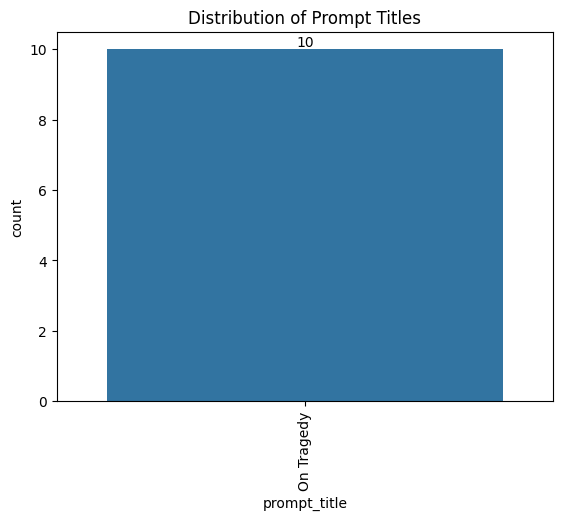

In [24]:
ax = sns.countplot(x="prompt_title", data=df_train)
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("Distribution of Prompt Titles")
plt.show()

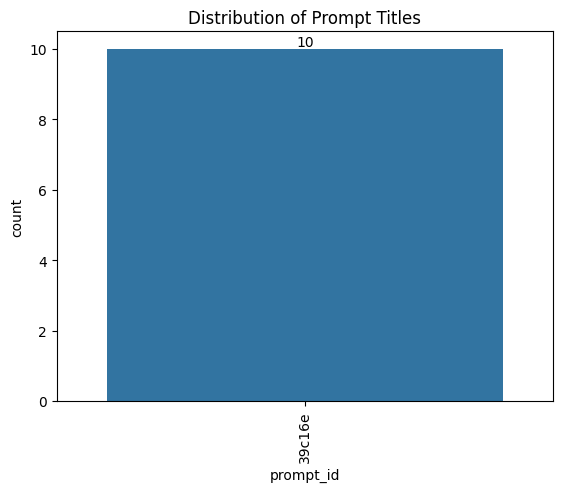

In [25]:
ax = sns.countplot(x="prompt_id", data=df_train)
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("Distribution of Prompt Titles")
plt.show()

[Text(0.5, 1.0, 'Character Count')]

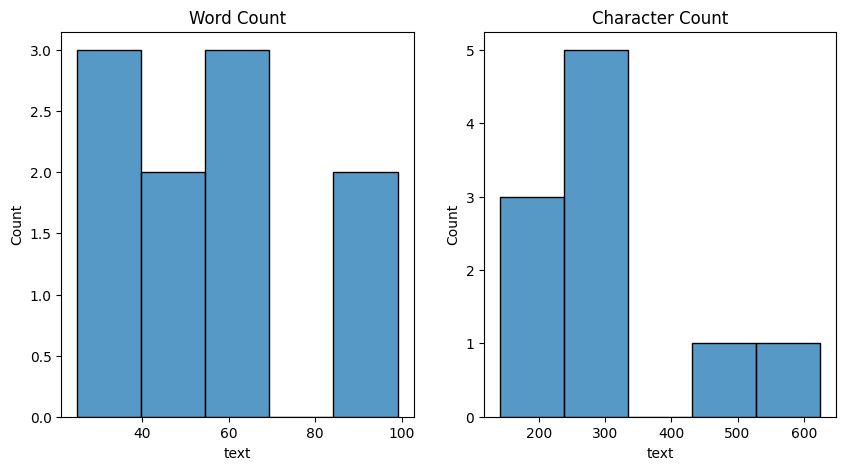

In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(x=df_train["text"].apply(
    lambda x: len(x.split()))).set(title="Word Count")
plt.subplot(1, 2, 2)
sns.histplot(x=df_train["text"].apply(lambda x: len(x))
             ).set(title="Character Count")

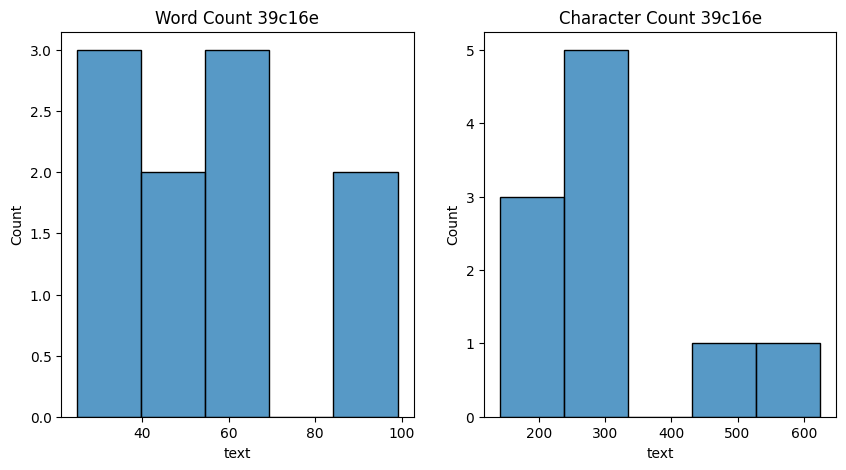

In [27]:
for i in df_train["prompt_id"].unique():
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(
        x=df_train[df_train["prompt_id"] == i]["text"].apply(
            lambda x: len(x.split()))
    ).set(title="Word Count " + str(i))
    plt.subplot(1, 2, 2)
    sns.histplot(
        x=df_train[df_train["prompt_id"] == i]["text"].apply(lambda x: len(x))
    ).set(title="Character Count " + str(i))

In [28]:
# most frequent words in the text column
print("Most Frequent Words in the Text Column")
Counter(" ".join(df_train["text"]).split()).most_common(20)

Most Frequent Words in the Text Column


[('the', 28),
 ('a', 23),
 ('that', 17),
 ('and', 17),
 ('of', 16),
 ('have', 15),
 ('should', 14),
 ('is', 13),
 ('tragedy', 12),
 ('to', 11),
 ('it', 9),
 ('an', 8),
 ('ideal', 8),
 ('be', 8),
 ('good', 7),
 ('element', 6),
 ('character', 6),
 ('on', 5),
 ('complex', 5),
 ('The', 5)]

In [29]:
# most frequent words by prompt id
for i in df_train["prompt_id"].unique():
    print("Most Frequent Words in the Text Column for Prompt ID", i)
    print(
        Counter(
            " ".join(df_train[df_train["prompt_id"] == i]["text"]).split()
        ).most_common(20)
    )

Most Frequent Words in the Text Column for Prompt ID 39c16e
[('the', 28), ('a', 23), ('that', 17), ('and', 17), ('of', 16), ('have', 15), ('should', 14), ('is', 13), ('tragedy', 12), ('to', 11), ('it', 9), ('an', 8), ('ideal', 8), ('be', 8), ('good', 7), ('element', 6), ('character', 6), ('on', 5), ('complex', 5), ('The', 5)]


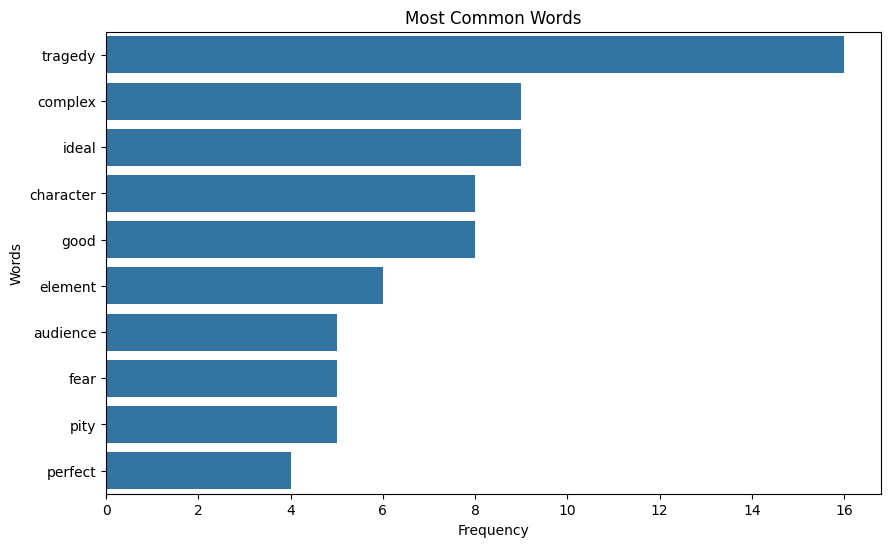

In [30]:
# print most frequent words
all_text = " ".join(df_train["text"])

# Tokenize the text (split it into words)
words = nltk.word_tokenize(all_text)

# Remove stopwords (common words like 'the', 'and', 'in' that don't carry much meaning)
stop_words = set(stopwords.words("english"))
filtered_words = [
    word.lower() for word in words if word.isalpha() and word.lower() not in stop_words
]

# Count the frequency of each word
word_counts = pd.Series(filtered_words).value_counts()

# Get the most common words (you can adjust the number as needed)
most_common_words = word_counts.head(10)  # Change 10 to the desired number

# Plot the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=most_common_words.values, y=most_common_words.index)
plt.title("Most Common Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

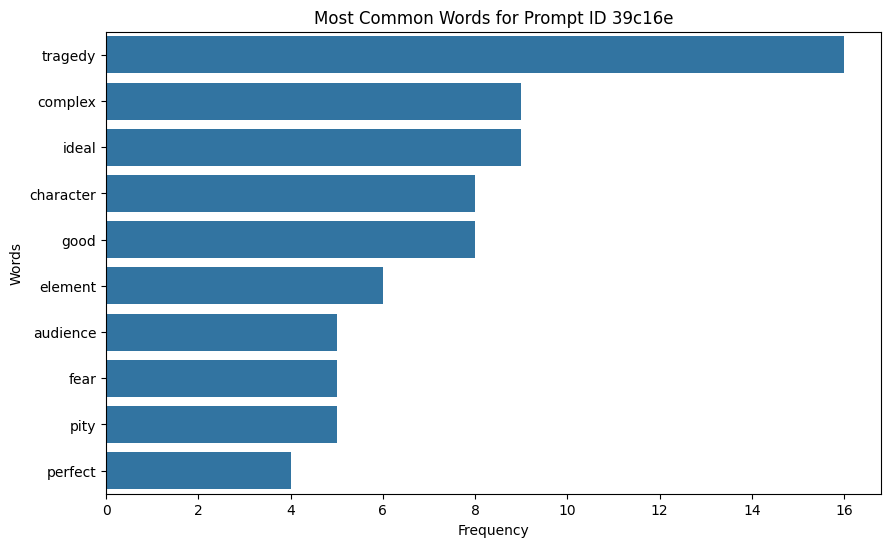

In [31]:
# print most frequent words by prompt id
for i in df_train["prompt_id"].unique():
    all_text = " ".join(df_train[df_train["prompt_id"] == i]["text"])
    words = nltk.word_tokenize(all_text)
    filtered_words = [
        word.lower()
        for word in words
        if word.isalpha() and word.lower() not in stop_words
    ]
    word_counts = pd.Series(filtered_words).value_counts()
    most_common_words = word_counts.head(10)  # Change 10 to the desired number
    plt.figure(figsize=(10, 6))
    sns.barplot(x=most_common_words.values, y=most_common_words.index)
    plt.title("Most Common Words for Prompt ID " + str(i))
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

<Axes: >

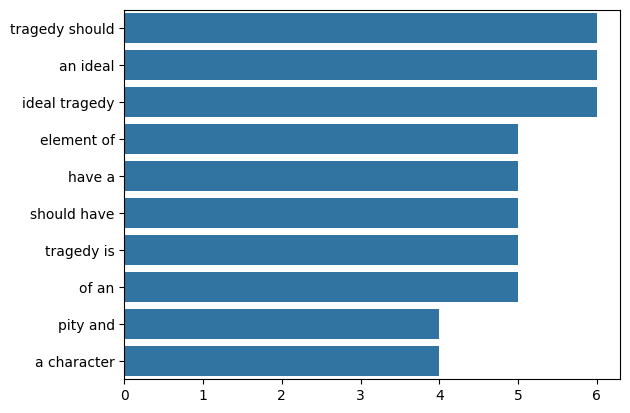

In [32]:
# Pairs of Words using Ngrams
frequent = (
    df_train["text"]
    .apply(lambda x: list(ngrams(x.split(), 2)))
    .explode()
    .value_counts()
)
x, y = [], []
for word, count in enumerate(frequent):
    if len(x) == 10:
        break
    x.append(" ".join(frequent.index[word]))
    y.append(count)
sns.barplot(x=y, y=x)

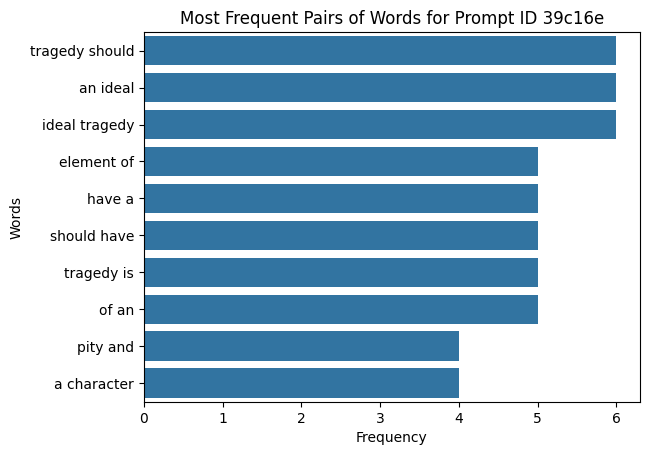

In [33]:
# print pairs of words by prompt id
for i in df_train["prompt_id"].unique():
    frequent = (
        df_train[df_train["prompt_id"] == i]["text"]
        .apply(lambda x: list(ngrams(x.split(), 2)))
        .explode()
        .value_counts()
    )
    x, y = [], []
    for word, count in enumerate(frequent):
        if len(x) == 10:
            break
        x.append(" ".join(frequent.index[word]))
        y.append(count)
    sns.barplot(x=y, y=x)
    plt.title("Most Frequent Pairs of Words for Prompt ID " + str(i))
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

<Axes: >

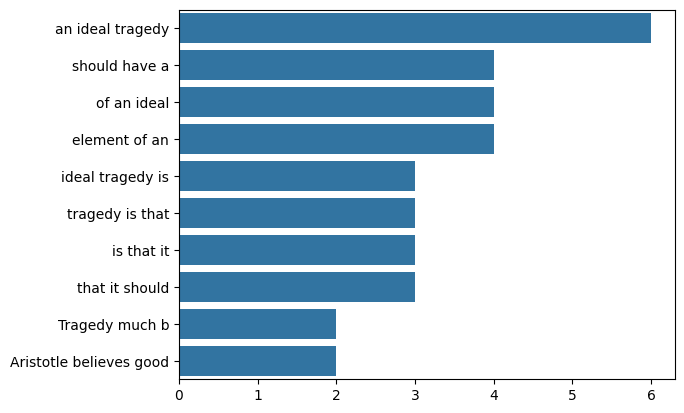

In [34]:
# Pairs of Words using Ngrams
frequent = (
    df_train["text"]
    .apply(lambda x: list(ngrams(x.split(), 3)))
    .explode()
    .value_counts()
)
x, y = [], []
for word, count in enumerate(frequent):
    if len(x) == 10:
        break
    x.append(" ".join(frequent.index[word]))
    y.append(count)
sns.barplot(x=y, y=x)

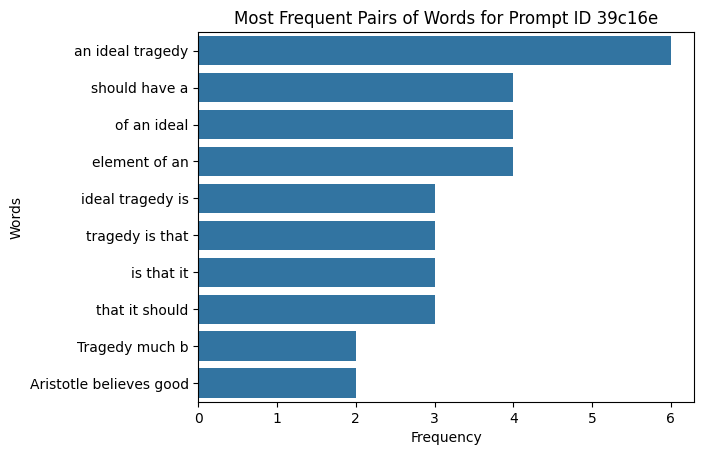

In [35]:
# print pairs of words by prompt id
for i in df_train["prompt_id"].unique():
    frequent = (
        df_train[df_train["prompt_id"] == i]["text"]
        .apply(lambda x: list(ngrams(x.split(), 3)))
        .explode()
        .value_counts()
    )
    x, y = [], []
    for word, count in enumerate(frequent):
        if len(x) == 10:
            break
        x.append(" ".join(frequent.index[word]))
        y.append(count)
    sns.barplot(x=y, y=x)
    plt.title("Most Frequent Pairs of Words for Prompt ID " + str(i))
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

<Axes: xlabel='content', ylabel='Count'>

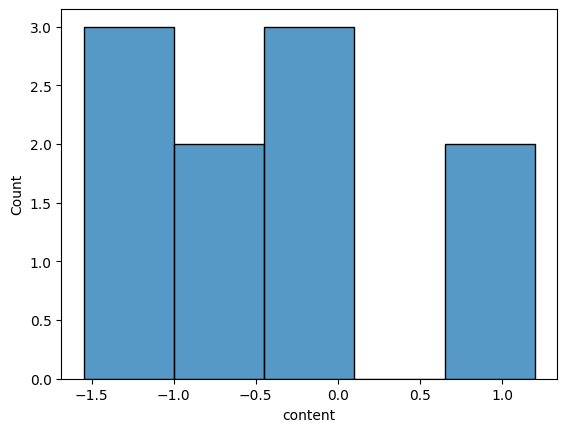

In [36]:
# Content
sns.histplot(df_train["content"])

<Axes: xlabel='wording', ylabel='Count'>

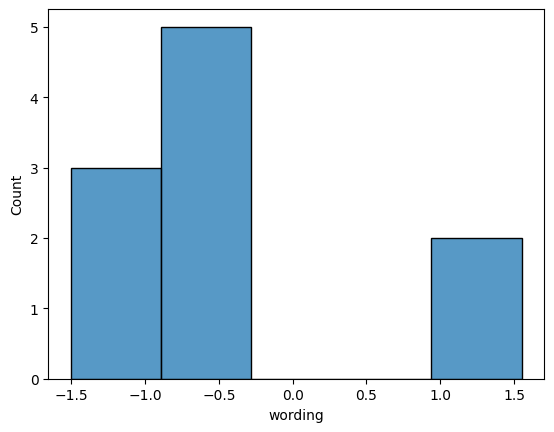

In [37]:
# Wording
sns.histplot(df_train["wording"])

In [38]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [39]:
# Preprocess and tokenize the training data
class TextDataset(Dataset):
    def __init__(self, encodings, content, wording):
        self.encodings = encodings
        self.content = content
        self.wording = wording

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
                for key, val in self.encodings.items()}
        item["content"] = torch.tensor(self.content[idx])
        item["wording"] = torch.tensor(self.wording[idx])
        return item

    def __len__(self):
        return len(self.content)

In [40]:
train_texts = df_train["text"].tolist()
train_content = df_train["content"].tolist()
train_wording = df_train["wording"].tolist()

In [41]:
train_encodings = tokenizer(
    train_texts, truncation=True, padding=True, max_length=512)
train_dataset = TextDataset(train_encodings, train_content, train_wording)

In [42]:
# Split the training dataset into train and validation sets
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2)

In [43]:
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [45]:
# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = MSELoss()

In [46]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [47]:
# Training loop
for epoch in range(50):  # number of epochs
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = torch.stack(
            (batch["content"], batch["wording"]), dim=1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = torch.stack(
                (batch["content"], batch["wording"]), dim=1).to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch}: Validation Loss: {average_val_loss}")

Epoch 0: Validation Loss: 1.1817538738250732
Epoch 1: Validation Loss: 1.2083946466445923
Epoch 2: Validation Loss: 1.2307153940200806
Epoch 3: Validation Loss: 1.2532219886779785
Epoch 4: Validation Loss: 1.2761776447296143
Epoch 5: Validation Loss: 1.301453709602356
Epoch 6: Validation Loss: 1.3299274444580078
Epoch 7: Validation Loss: 1.364717960357666
Epoch 8: Validation Loss: 1.4014698266983032
Epoch 9: Validation Loss: 1.4403706789016724
Epoch 10: Validation Loss: 1.4838345050811768
Epoch 11: Validation Loss: 1.528800129890442
Epoch 12: Validation Loss: 1.5612685680389404
Epoch 13: Validation Loss: 1.5843580961227417
Epoch 14: Validation Loss: 1.591675877571106
Epoch 15: Validation Loss: 1.5889122486114502
Epoch 16: Validation Loss: 1.5800728797912598
Epoch 17: Validation Loss: 1.5675519704818726
Epoch 18: Validation Loss: 1.5531005859375
Epoch 19: Validation Loss: 1.5379173755645752
Epoch 20: Validation Loss: 1.5218040943145752
Epoch 21: Validation Loss: 1.5066118240356445
Epoch

In [48]:
# Load and preprocess df_test
test_texts = df_test["text"].tolist()

# Tokenization for test data
test_encodings = tokenizer(test_texts, truncation=True,
                           padding=True, max_length=512)

In [49]:
# Create a dataset for test data
class TestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings["input_ids"])


test_dataset = TestDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=16)

In [50]:
# Generate predictions for test dataset
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.cpu().numpy())

In [51]:
# print predictions
print(predictions)

[array([-0.3954726 , -0.39835677], dtype=float32), array([-0.28172106, -0.40517354], dtype=float32), array([-0.3510505 , -0.41761068], dtype=float32), array([-0.3115177 , -0.39508805], dtype=float32)]


In [53]:
# print the test accuracy and loss
print("Test Loss:", average_val_loss)

Test Loss: 1.3760424852371216
